<a href="https://colab.research.google.com/github/So-That/sothat-nlp/blob/main/SBerts_Kmeans_findingK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##댓글 전처리(형태소 분석 ) SBert-KMeans

In [19]:
!pip install sentence_transformers

import pandas as pd
import re
from konlpy.tag import Okt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import json

# 댓글 전처리
with open('stopwords.txt', 'r', encoding='utf-8-sig') as f:
    stopwords = set(f.read().split(","))

def clean_and_tokenize(text):

    text = re.sub(r"<.*?>", " ", text)  # HTML 태그 제거
    text = re.sub(r"[^\w\s가-힣]", " ", text)  # 특수문자 제거
    text = re.sub(r"(ㅋ|ㅎ|ㅜ|ㅠ|ㄷ|ㅌ|ㄱ|ㅂ|ㅇ|ㄴ|ㅅ|ㅈ|ㅊ){1,}", " ", text)  # 반복 자음 제거
    text = re.sub(r"\s+", " ", text).strip()  # 공백 정리)

    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords]
    return " ".join(tokens)


"""  형태소 분석을 통한 전처리
!pip install konlpy

okt = Okt()
# 형태소 분석 + 불용어 제거
def clean_and_tokenize(text):
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^\w\s가-힣]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"(ㅋ|ㅎ|ㅜ|ㅠ|ㄷ|ㅌ|ㄱ|ㅂ|ㅇ|ㄴ|ㅅ|ㅈ|ㅊ){1,}", " ", text)
    tokens = okt.morphs(text, stem=True)
    tokens = [t for t in tokens if t not in stopwords]
    return " ".join([w for w in tokens if w not in stopwords])
"""


# JSON 파일 불러오기
with open("/content/response_600.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# reply 필드만 추출해서 리스트로 만들기
sentences = [item["reply"] for item in data if "reply" in item and isinstance(item["reply"], str)]

### 전처리된 댓글 파일로 저장
processed_data = [{"reply": clean_and_tokenize(s)} for s in sentences]

# JSON 파일로 저장
with open("cleaned_response_600.json", "w", encoding="utf-8") as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=2)

# SBERT 모델 로드
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# 원문 vs 전처리 문장 임베딩
raw_embeddings = model.encode(sentences)
clean_embeddings = model.encode(processed_data)



###시각화

In [ ]:


def cluster_and_plot(embeddings, title):
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    reduced = PCA(n_components=2).fit_transform(embeddings)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='Set2')
    for i in range(len(reduced)):
        plt.annotate(i, (reduced[i, 0], reduced[i, 1]), fontsize=9)
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

    return labels
# 클러스터링 결과 받아오기
clean_labels = cluster_and_plot(clean_embeddings, "Cleaned SBERT")

# 클러스터별 댓글 정리 및 출력
clustered_comments = {i: [] for i in range(4)}  # 클러스터 0~3번

for idx, label in enumerate(clean_labels):
    clustered_comments[label].append((idx, processed_data[idx]))

# 출력
print("\n=== 클러스터별 댓글 ===")
for cluster_id, comments in clustered_comments.items():
    print(f"\n[클러스터 {cluster_id}] ({len(comments)}개)")
    for idx, sentence in comments:
        print(f"{idx+1}. {sentence}")


# K 찾기

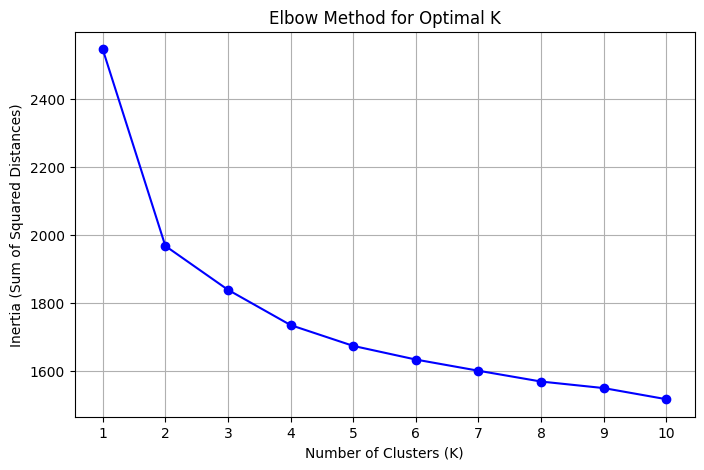

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer



# K값을 1부터 10까지 변경하면서 Inertia 계산
inertia_values = []
K_range = range(1, 11)

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    kmeans.fit(clean_embeddings)
    inertia_values.append(kmeans.inertia_)

# 그래프 출력
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")
plt.xticks(K_range)
plt.grid(True)
plt.show()
